In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 폴더에서 우클릭해서 경로복사
%cd /content/drive/MyDrive/Day5_HM_crop256

/content/drive/MyDrive/Day5_HM_crop256


In [3]:
!pip install albumentations==0.4.6

     |████████████████████████████████| 122kB 12.3MB/s 
     |████████████████████████████████| 952kB 10.8MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp37-none-any.whl size=65163 sha256=39da7071911e6ae79f1d5b5ac712e5abf892ca71e47cc5ecc4852199b1c4d0fc
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [48]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import cv2
from tqdm.auto import tqdm
from utils import *

import numpy as np
import pandas as pd

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations import *
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

plt.rcParams['axes.grid'] = False

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

pytorch version: 1.8.1+cu101
GPU 사용 가능 여부: True
Tesla P100-PCIE-16GB
1


In [49]:
batch_size = 8  # Mini-batch size
num_epochs = 20
learning_rate = 1e-4

# seed 고정
random_seed = 21
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
# torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [50]:
%matplotlib inline

dataset_path = './data'
anns_file_path = dataset_path + '/' + 'train.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 11
Number of categories: 11
Number of annotations: 21116
Number of images: 2617


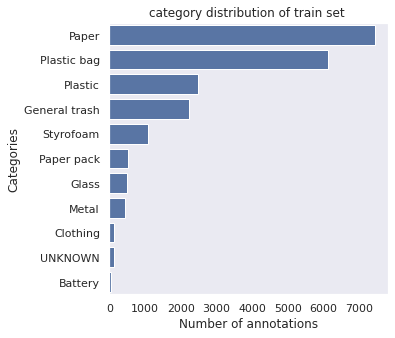

In [51]:
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,5))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
plt.title("category distribution of train set ")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df, label="Total", color="b")

In [52]:
# category labeling 
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)

# class (Categories) 에 따른 index 확인 (0~11 : 총 12개)
sorted_df

,Categories,Number of annotations
0,Backgroud,NaN
1,UNKNOWN,128.0
2,General trash,2225.0
3,Paper,7448.0
4,Paper pack,527.0
5,Metal,449.0
6,Glass,488.0
7,Plastic,2472.0
8,Styrofoam,1074.0
9,Plastic bag,6114.0


## DataLoader 정의

In [53]:
category_names = list(sorted_df.Categories)

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id + 1" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # Unknown = 1, General trash = 2, ... , Cigarette = 11
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks = np.maximum(self.coco.annToMask(anns[i])*pixel_value, masks)
            masks = masks.astype(np.float32)

            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            
            return images, image_infos
    
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

## Dataset 만들기

In [54]:
# train.json / validation.json / test.json 디렉토리 설정
train_path = dataset_path + '/train.json'
val_path = dataset_path + '/val.json'
test_path = dataset_path + '/test.json'

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

train_transform = A.Compose([
                  RandomCrop(256,256),  ## Changed!! ##
                  #Resize(height=CFG['resize'], width=CFG['resize'], p=1.0),
                  ShiftScaleRotate(border_mode=1),
                  GridDistortion(border_mode=1),
                  Blur(blur_limit=1),
                  HorizontalFlip(p=0.5),
                  Rotate(border_mode=1),
                  RandomBrightnessContrast(),
#                   Normalize(mean = [0.485, 0.456, 0.406], 
#                             std = [0.229, 0.224, 0.225],
#                             max_pixel_value=1.0 ,
#                             p = 1.0
#                            ),
                  Cutout(p=0.5),
                  ToTensorV2(p=1.0),
      ], p = 1.0)

val_transform = A.Compose([
            #Resize(height=CFG['resize'], width=CFG['resize'], p=1.0),
#             Normalize(mean = [0.485, 0.456, 0.406], 
#                             std = [0.229, 0.224, 0.225],
#                             max_pixel_value=1.0 ,
#                             p = 1.0
#                            ),
            ToTensorV2(p=1.0),
            
        ], p = 1.0)

test_transform = A.Compose([
            #Resize(height=CFG['resize'], width=CFG['resize'], p=1.0),
#             Normalize(mean = [0.485, 0.456, 0.406], 
#                             std = [0.229, 0.224, 0.225],
#                             max_pixel_value=1.0 ,
#                             p = 1.0
#                            ),
            ToTensorV2(p=1.0),
            
        ], p = 1.0)


# train dataset
train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)

# validation dataset
val_dataset = CustomDataLoader(data_dir=val_path, mode='val', transform=val_transform)

# test dataset
test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)


# DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=0,
                                           collate_fn=collate_fn,
                                           drop_last=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=0,
                                         collate_fn=collate_fn,
                                         drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          num_workers=1,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=3.31s)
creating index...
index created!
loading annotations into memory...
Done (t=0.91s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


## Pre-trained model

In [55]:
import segmentation_models_pytorch as smp
model = smp.DeepLabV3Plus('se_resnet50', classes=12)

# 구현된 model에 임의의 input을 넣어 output이 잘 나오는지 test
# x = torch.randn([5, 3, 512, 512])
# print("input shape : ", x.shape)
# out = model(x).to(device)
# print("output shape : ", out.size())

model = model.to(device)

## train, validation, test 함수 정의

In [15]:
# def class_score(avrg_class_IoU):
#     # Class Score
#     class_name=['BG','UNK','General Trash','Paper','Paper pack','Metal','Glass','Plastic','Styrofoam','Plastic Bag','Battery','Clothing']
#     print('-'*20)
#     print('Validation Class Pred mIoU Score')
#     for idx, class_score in enumerate(avrg_class_IoU):
#         print('[{}] mIoU : [{:.4f}]'.format(class_name[idx],class_score))
#     print('-'*20)

In [57]:
def train(num_epochs, model, data_loader, val_loader, criterion, optimizer, saved_dir, device):
    # scheduler 지움!!
    print('Start training..')
    best_loss = 9999999
    best_IoU = 0
    for epoch in range(num_epochs):
        model.train()
        train_loss = []
        for step, (images, masks, _) in enumerate(tqdm(data_loader)):
            
            images = torch.stack(images)       # (batch, channel, height, width)
            masks = torch.stack(masks).long()  # (batch, channel, height, width)
            
            # gpu 연산을 위해 device 할당
            images, masks = images.to(device), masks.to(device) 
            # images: torch.Size([batch,3,256,256]) 
            # masks : torch.Size([batch,256,256])
            # print('Train image and mask')
            # fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))
            # ax1.imshow(images[0].cpu().permute([1,2,0]))  
            # ax1.grid(False)
            # ax2.imshow(masks[0].cpu())
            # ax2.grid(False)
            # plt.show()


            # inference
            outputs = model(images)   # (batch,12,256,256): 픽셀별로 각 클래스에 속할 확률(logit)
            # print(outputs.detach().cpu().numpy().shape)

            # loss 계산 (cross entropy loss)
            loss = criterion(outputs, masks)
            train_loss.append(loss.item())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
#             scheduler.step(epoch + step / len(data_loader))
            
            # step 주기에 따른 loss 출력
            if (step + 1) % 25 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{step+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
        # validation 주기에 따른 loss 출력 및 best model 저장
        avrg_loss, avrg_IoU = validation(epoch+1, model, val_loader, criterion, device)
        
        # avrg_loss, avrg_IoU, avrg_class_IoU = validation(epoch, model, val_loader, criterion, device)
        # print('Epoch [{}/{}], Train Loss: {:.4f} Vali Loss: {:.4f}, Vali mIoU: {:.4f}'.format(epoch+1, num_epochs, np.mean(train_loss), avrg_loss, avrg_IoU))
        
        # Class Score
        # class_score(avrg_class_IoU)
            
        if avrg_loss < best_loss:
            print(f'Best loss performance at epoch: {epoch + 1}')
            best_loss = avrg_loss
            save_model(model, saved_dir, epoch+1, 'loss')
        if avrg_IoU > best_IoU:
            print(f'Best mIoU performance at epoch: {epoch + 1}')
            best_IoU = avrg_IoU
            save_model(model, saved_dir, epoch+1, 'mIoU')

In [58]:
def validation(epoch, model, data_loader, criterion, device):
    n_class=12
    hist = np.zeros((n_class, n_class))
    print(f'Start validation #{epoch}')
    model.eval()
    with torch.no_grad():
        total_loss = 0
        cnt = 0
        mIoU_list = []
        for step, (images, masks, _) in enumerate(tqdm(data_loader)):
            
            images = torch.stack(images)       # (batch, channel, height, width)
            masks = torch.stack(masks).long()  # (batch, channel, height, width)

            # images, masks = images.to(device), masks.to(device) 
            # images: torch.Size([batch,3,512,512])
            # masks : torch.Size([batch,512,512])
            
            # fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))
            # ax1.imshow(images[0].cpu().permute([1,2,0]))  
            # ax1.grid(False)
            # ax2.imshow(masks[0].cpu())
            # ax2.grid(False)
            # plt.show()
            
            #==== Inference by sliding window ====#
            # Split images into 4 sub-images and inference each sub-image
            h, w = images.size(2), images.size(3)  # 512, 512
            h_sub, w_sub = h//2, w//2 # 256, 256
            
            start_points = [(0,0),(0,w_sub),(h_sub,0),(h_sub,w_sub)] # each left-top point
            outputs = torch.zeros_like(torch.empty(batch_size,n_class,h,w)) # [batch, 12, 512, 512]
            
            for sx,sy in start_points:
                subimg = images[:,:, sx:sx+h_sub, sy:sy+w_sub].to(device)
                outputs[:,:,sx:sx+h_sub, sy:sy+w_sub] = model(subimg)  # (batch,12,256,256)

            # print('# ---- CE loss ----')
            outputs, masks = outputs.to(device), masks.to(device)
            loss = criterion(outputs, masks)
            total_loss += loss
            cnt += 1
            
            # print('# ---- argmax ----')
            if batch_size == 1:
                outputs = torch.argmax(outputs, dim=1).detach().cpu().numpy()
            outputs = torch.argmax(outputs.squeeze(), dim=1).detach().cpu().numpy()
            
            mIoU = label_accuracy_score(masks.detach().cpu().numpy(), outputs, n_class=12)[2]
            mIoU_list.append(mIoU)
            
            # print('Splitted sub-images and masks')
            # fig, ((ax1,ax2,ax3,ax4), (ax5,ax6,ax7,ax8)) = plt.subplots(nrows=2, ncols=4, figsize=(14,12))
            # ax1.imshow(images_splitted[0].cpu().permute([1,2,0]))
            # ax1.grid(False)
            # ax2.imshow(images_splitted[1].cpu().permute([1,2,0]))
            # ax2.grid(False)
            # ax5.imshow(images_splitted[2].cpu().permute([1,2,0]))
            # ax5.grid(False)
            # ax6.imshow(images_splitted[3].cpu().permute([1,2,0]))
            # ax6.grid(False)

            # ax3.imshow(masks_splitted[0].cpu())
            # ax3.grid(False)
            # ax4.imshow(masks_splitted[1].cpu())
            # ax4.grid(False)
            # ax7.imshow(masks_splitted[2].cpu())
            # ax7.grid(False)
            # ax8.imshow(masks_splitted[3].cpu())
            # ax8.grid(False)
            # plt.show()

            
            ### add_hist -> utils.py에 추가했음 ###
            # hist = add_hist(hist, masks.detach().cpu().numpy(), outputs, n_class=n_class)

        # val_mIoU, val_class_mIoU = label_accuracy_score(hist)
        avrg_loss = total_loss / cnt
        avrg_mIoU = np.nanmean(mIoU_list)
        print(f'Validation #{epoch}  Average Loss: {avrg_loss:.4f}, mIoU: {avrg_mIoU:.4f}')
    return avrg_loss, avrg_mIoU

## 모델 저장 함수 정의

In [59]:
saved_dir = './saved/0501'
if not os.path.isdir(saved_dir):                                                           
    os.mkdir(saved_dir)
    
def save_model(model, saved_dir, epoch, typ):
    file_name=f'DeepV3Plus_SE-Net_AllAug_crop256_{epoch}_{typ}.pt'
    check_point = {'net': model.state_dict()}
    output_path = os.path.join(saved_dir, file_name)
    torch.save(model.state_dict(), output_path)

## 모델 생성 및 Loss function, Optimizer 정의

In [60]:
# Loss function 정의
criterion = nn.CrossEntropyLoss()

# Optimizer 정의
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate, weight_decay=1e-6)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, eta_min=1.2e-8) -> 기민님 코드

In [61]:
train(num_epochs, model, train_loader, val_loader, criterion, optimizer, saved_dir, device) # scheduler 지움

Start training..


Epoch [1/20], Step [25/327], Loss: 1.7852
Epoch [1/20], Step [50/327], Loss: 1.5197
Epoch [1/20], Step [75/327], Loss: 1.0884
Epoch [1/20], Step [100/327], Loss: 1.2815
Epoch [1/20], Step [125/327], Loss: 1.2490
Epoch [1/20], Step [150/327], Loss: 0.6262
Epoch [1/20], Step [175/327], Loss: 0.8514
Epoch [1/20], Step [200/327], Loss: 0.8401
Epoch [1/20], Step [225/327], Loss: 1.2676
Epoch [1/20], Step [250/327], Loss: 0.6304
Epoch [1/20], Step [275/327], Loss: 0.9130
Epoch [1/20], Step [300/327], Loss: 1.0413
Epoch [1/20], Step [325/327], Loss: 0.8781

Start validation #1



Validation #1  Average Loss: 0.5228, mIoU: 0.2997
Best loss performance at epoch: 1
Best mIoU performance at epoch: 1


Epoch [2/20], Step [25/327], Loss: 0.7987
Epoch [2/20], Step [50/327], Loss: 0.9668
Epoch [2/20], Step [75/327], Loss: 0.9514
Epoch [2/20], Step [100/327], Loss: 0.4366
Epoch [2/20], Step [125/327], Loss: 0.4685
Epoch [2/20], Step [150/327], Loss: 0.4391
Epoch [2/20], Step [175/327], Loss: 0.6194
Epoch [2/20], Step [200/327], Loss: 1.0615
Epoch [2/20], Step [225/327], Loss: 0.7782
Epoch [2/20], Step [250/327], Loss: 0.5856
Epoch [2/20], Step [275/327], Loss: 0.6535
Epoch [2/20], Step [300/327], Loss: 0.4635
Epoch [2/20], Step [325/327], Loss: 0.6338

Start validation #2



Validation #2  Average Loss: 0.4466, mIoU: 0.3090
Best loss performance at epoch: 2
Best mIoU performance at epoch: 2


Epoch [3/20], Step [25/327], Loss: 0.6893
Epoch [3/20], Step [50/327], Loss: 0.5418
Epoch [3/20], Step [75/327], Loss: 0.6576
Epoch [3/20], Step [100/327], Loss: 0.4425
Epoch [3/20], Step [125/327], Loss: 0.7451
Epoch [3/20], Step [150/327], Loss: 0.5108
Epoch [3/20], Step [175/327], Loss: 0.8227
Epoch [3/20], Step [200/327], Loss: 0.9836
Epoch [3/20], Step [225/327], Loss: 0.7737
Epoch [3/20], Step [250/327], Loss: 0.8679
Epoch [3/20], Step [275/327], Loss: 0.6644
Epoch [3/20], Step [300/327], Loss: 0.7269
Epoch [3/20], Step [325/327], Loss: 0.5168

Start validation #3



Validation #3  Average Loss: 0.4390, mIoU: 0.3155
Best loss performance at epoch: 3
Best mIoU performance at epoch: 3


Epoch [4/20], Step [25/327], Loss: 0.5717
Epoch [4/20], Step [50/327], Loss: 0.3933
Epoch [4/20], Step [75/327], Loss: 0.7122
Epoch [4/20], Step [100/327], Loss: 0.7341
Epoch [4/20], Step [125/327], Loss: 0.6383
Epoch [4/20], Step [150/327], Loss: 0.5152
Epoch [4/20], Step [175/327], Loss: 0.7345
Epoch [4/20], Step [200/327], Loss: 0.9524
Epoch [4/20], Step [225/327], Loss: 0.6593
Epoch [4/20], Step [250/327], Loss: 0.6249
Epoch [4/20], Step [275/327], Loss: 0.9882
Epoch [4/20], Step [300/327], Loss: 1.2292
Epoch [4/20], Step [325/327], Loss: 0.7634

Start validation #4



Validation #4  Average Loss: 0.3999, mIoU: 0.3256
Best loss performance at epoch: 4
Best mIoU performance at epoch: 4


Epoch [5/20], Step [25/327], Loss: 0.5425
Epoch [5/20], Step [50/327], Loss: 0.8296
Epoch [5/20], Step [75/327], Loss: 0.4452
Epoch [5/20], Step [100/327], Loss: 0.9846
Epoch [5/20], Step [125/327], Loss: 0.5794
Epoch [5/20], Step [150/327], Loss: 0.9176
Epoch [5/20], Step [175/327], Loss: 0.4537
Epoch [5/20], Step [200/327], Loss: 0.6082
Epoch [5/20], Step [225/327], Loss: 0.4862
Epoch [5/20], Step [250/327], Loss: 0.6072
Epoch [5/20], Step [275/327], Loss: 0.4044
Epoch [5/20], Step [300/327], Loss: 0.5741
Epoch [5/20], Step [325/327], Loss: 0.5467

Start validation #5



Validation #5  Average Loss: 0.4325, mIoU: 0.3154


Epoch [6/20], Step [25/327], Loss: 0.8158
Epoch [6/20], Step [50/327], Loss: 0.5197
Epoch [6/20], Step [75/327], Loss: 0.6401
Epoch [6/20], Step [100/327], Loss: 1.0030
Epoch [6/20], Step [125/327], Loss: 0.4669
Epoch [6/20], Step [150/327], Loss: 0.4331
Epoch [6/20], Step [175/327], Loss: 0.5445
Epoch [6/20], Step [200/327], Loss: 0.7833
Epoch [6/20], Step [225/327], Loss: 0.4183
Epoch [6/20], Step [250/327], Loss: 0.4287
Epoch [6/20], Step [275/327], Loss: 0.4538
Epoch [6/20], Step [300/327], Loss: 0.4801
Epoch [6/20], Step [325/327], Loss: 0.6641

Start validation #6



Validation #6  Average Loss: 0.4028, mIoU: 0.3456
Best mIoU performance at epoch: 6


Epoch [7/20], Step [25/327], Loss: 0.7515
Epoch [7/20], Step [50/327], Loss: 0.8294
Epoch [7/20], Step [75/327], Loss: 0.4836
Epoch [7/20], Step [100/327], Loss: 0.4549
Epoch [7/20], Step [125/327], Loss: 0.4223
Epoch [7/20], Step [150/327], Loss: 0.5597
Epoch [7/20], Step [175/327], Loss: 1.0880
Epoch [7/20], Step [200/327], Loss: 0.8091
Epoch [7/20], Step [225/327], Loss: 0.4180
Epoch [7/20], Step [250/327], Loss: 0.4458
Epoch [7/20], Step [275/327], Loss: 0.7269
Epoch [7/20], Step [300/327], Loss: 0.4067
Epoch [7/20], Step [325/327], Loss: 0.8292

Start validation #7



Validation #7  Average Loss: 0.3822, mIoU: 0.3474
Best loss performance at epoch: 7
Best mIoU performance at epoch: 7


Epoch [8/20], Step [25/327], Loss: 0.4686
Epoch [8/20], Step [50/327], Loss: 0.7820
Epoch [8/20], Step [75/327], Loss: 0.7917
Epoch [8/20], Step [100/327], Loss: 0.6487
Epoch [8/20], Step [125/327], Loss: 0.6052
Epoch [8/20], Step [150/327], Loss: 0.7544
Epoch [8/20], Step [175/327], Loss: 0.4885
Epoch [8/20], Step [200/327], Loss: 0.2496
Epoch [8/20], Step [225/327], Loss: 0.6428
Epoch [8/20], Step [250/327], Loss: 0.5412
Epoch [8/20], Step [275/327], Loss: 0.3752
Epoch [8/20], Step [300/327], Loss: 1.0096
Epoch [8/20], Step [325/327], Loss: 0.3647

Start validation #8



Validation #8  Average Loss: 0.4232, mIoU: 0.3273


Epoch [9/20], Step [25/327], Loss: 0.2515
Epoch [9/20], Step [50/327], Loss: 0.5333
Epoch [9/20], Step [75/327], Loss: 0.6419
Epoch [9/20], Step [100/327], Loss: 0.8246
Epoch [9/20], Step [125/327], Loss: 0.7332
Epoch [9/20], Step [150/327], Loss: 0.4227
Epoch [9/20], Step [175/327], Loss: 0.6743
Epoch [9/20], Step [200/327], Loss: 0.7488
Epoch [9/20], Step [225/327], Loss: 0.6404
Epoch [9/20], Step [250/327], Loss: 0.6684
Epoch [9/20], Step [275/327], Loss: 0.5654
Epoch [9/20], Step [300/327], Loss: 0.5650
Epoch [9/20], Step [325/327], Loss: 0.6875

Start validation #9



Validation #9  Average Loss: 0.4210, mIoU: 0.3289


Epoch [10/20], Step [25/327], Loss: 0.6541
Epoch [10/20], Step [50/327], Loss: 0.5339
Epoch [10/20], Step [75/327], Loss: 0.5962
Epoch [10/20], Step [100/327], Loss: 0.3025
Epoch [10/20], Step [125/327], Loss: 0.3324
Epoch [10/20], Step [150/327], Loss: 0.3849
Epoch [10/20], Step [175/327], Loss: 0.6542
Epoch [10/20], Step [200/327], Loss: 0.9973
Epoch [10/20], Step [225/327], Loss: 0.5181
Epoch [10/20], Step [250/327], Loss: 0.9920
Epoch [10/20], Step [275/327], Loss: 0.4038
Epoch [10/20], Step [300/327], Loss: 0.3211
Epoch [10/20], Step [325/327], Loss: 0.6433

Start validation #10



Validation #10  Average Loss: 0.4741, mIoU: 0.3238


Epoch [11/20], Step [25/327], Loss: 0.7366
Epoch [11/20], Step [50/327], Loss: 0.6120
Epoch [11/20], Step [75/327], Loss: 0.3209
Epoch [11/20], Step [100/327], Loss: 0.7007
Epoch [11/20], Step [125/327], Loss: 1.1699
Epoch [11/20], Step [150/327], Loss: 0.1827
Epoch [11/20], Step [175/327], Loss: 0.4579
Epoch [11/20], Step [200/327], Loss: 0.4297
Epoch [11/20], Step [225/327], Loss: 0.5039
Epoch [11/20], Step [250/327], Loss: 0.4339
Epoch [11/20], Step [275/327], Loss: 0.4442
Epoch [11/20], Step [300/327], Loss: 0.5195
Epoch [11/20], Step [325/327], Loss: 0.9532

Start validation #11



Validation #11  Average Loss: 0.3825, mIoU: 0.3459


Epoch [12/20], Step [25/327], Loss: 0.2854
Epoch [12/20], Step [50/327], Loss: 0.4537
Epoch [12/20], Step [75/327], Loss: 0.4564
Epoch [12/20], Step [100/327], Loss: 0.4095
Epoch [12/20], Step [125/327], Loss: 0.6830
Epoch [12/20], Step [150/327], Loss: 0.5772
Epoch [12/20], Step [175/327], Loss: 0.3684
Epoch [12/20], Step [200/327], Loss: 0.8554
Epoch [12/20], Step [225/327], Loss: 0.2598
Epoch [12/20], Step [250/327], Loss: 0.5592
Epoch [12/20], Step [275/327], Loss: 0.4251
Epoch [12/20], Step [300/327], Loss: 0.4819
Epoch [12/20], Step [325/327], Loss: 0.4326

Start validation #12



Validation #12  Average Loss: 0.3859, mIoU: 0.3496
Best mIoU performance at epoch: 12


Epoch [13/20], Step [25/327], Loss: 0.7583
Epoch [13/20], Step [50/327], Loss: 0.4803
Epoch [13/20], Step [75/327], Loss: 0.3653
Epoch [13/20], Step [100/327], Loss: 0.2027
Epoch [13/20], Step [125/327], Loss: 0.5094
Epoch [13/20], Step [150/327], Loss: 0.8393
Epoch [13/20], Step [175/327], Loss: 0.4024
Epoch [13/20], Step [200/327], Loss: 0.5955
Epoch [13/20], Step [225/327], Loss: 0.4552
Epoch [13/20], Step [250/327], Loss: 0.6333
Epoch [13/20], Step [275/327], Loss: 0.4556
Epoch [13/20], Step [300/327], Loss: 0.5742
Epoch [13/20], Step [325/327], Loss: 0.5750

Start validation #13



Validation #13  Average Loss: 0.4173, mIoU: 0.3405


Epoch [14/20], Step [25/327], Loss: 0.3366
Epoch [14/20], Step [50/327], Loss: 0.5012
Epoch [14/20], Step [75/327], Loss: 0.3557
Epoch [14/20], Step [100/327], Loss: 0.5089
Epoch [14/20], Step [125/327], Loss: 0.3348
Epoch [14/20], Step [150/327], Loss: 0.1873
Epoch [14/20], Step [175/327], Loss: 0.8172
Epoch [14/20], Step [200/327], Loss: 0.4585
Epoch [14/20], Step [225/327], Loss: 0.7088
Epoch [14/20], Step [250/327], Loss: 0.4389
Epoch [14/20], Step [275/327], Loss: 0.4393
Epoch [14/20], Step [300/327], Loss: 0.4172
Epoch [14/20], Step [325/327], Loss: 0.3986

Start validation #14



Validation #14  Average Loss: 0.5574, mIoU: 0.3190


Epoch [15/20], Step [25/327], Loss: 0.3803
Epoch [15/20], Step [50/327], Loss: 0.4912
Epoch [15/20], Step [75/327], Loss: 0.3128
Epoch [15/20], Step [100/327], Loss: 0.5696
Epoch [15/20], Step [125/327], Loss: 0.5932
Epoch [15/20], Step [150/327], Loss: 0.2430
Epoch [15/20], Step [175/327], Loss: 0.3015
Epoch [15/20], Step [200/327], Loss: 0.2408
Epoch [15/20], Step [225/327], Loss: 0.5920
Epoch [15/20], Step [250/327], Loss: 0.4675
Epoch [15/20], Step [275/327], Loss: 0.2541
Epoch [15/20], Step [300/327], Loss: 0.3335
Epoch [15/20], Step [325/327], Loss: 0.6266

Start validation #15



Validation #15  Average Loss: 0.4234, mIoU: 0.3313


Epoch [16/20], Step [25/327], Loss: 0.6749
Epoch [16/20], Step [50/327], Loss: 0.4009
Epoch [16/20], Step [75/327], Loss: 0.3609
Epoch [16/20], Step [100/327], Loss: 0.2730
Epoch [16/20], Step [125/327], Loss: 0.5533
Epoch [16/20], Step [150/327], Loss: 0.9339
Epoch [16/20], Step [175/327], Loss: 0.5406
Epoch [16/20], Step [200/327], Loss: 0.3941
Epoch [16/20], Step [225/327], Loss: 0.4518
Epoch [16/20], Step [250/327], Loss: 0.3996
Epoch [16/20], Step [275/327], Loss: 0.3776
Epoch [16/20], Step [300/327], Loss: 0.4443
Epoch [16/20], Step [325/327], Loss: 0.5534

Start validation #16



Validation #16  Average Loss: 0.3563, mIoU: 0.3517
Best loss performance at epoch: 16
Best mIoU performance at epoch: 16


Epoch [17/20], Step [25/327], Loss: 0.4198
Epoch [17/20], Step [50/327], Loss: 0.5578
Epoch [17/20], Step [75/327], Loss: 0.3641
Epoch [17/20], Step [100/327], Loss: 0.4715
Epoch [17/20], Step [125/327], Loss: 0.6250
Epoch [17/20], Step [150/327], Loss: 0.3974
Epoch [17/20], Step [175/327], Loss: 0.5099
Epoch [17/20], Step [200/327], Loss: 0.4357
Epoch [17/20], Step [225/327], Loss: 0.4363
Epoch [17/20], Step [250/327], Loss: 0.6250
Epoch [17/20], Step [275/327], Loss: 0.4914
Epoch [17/20], Step [300/327], Loss: 0.3179
Epoch [17/20], Step [325/327], Loss: 0.5537

Start validation #17



Validation #17  Average Loss: 0.4008, mIoU: 0.3423


Epoch [18/20], Step [25/327], Loss: 0.3431
Epoch [18/20], Step [50/327], Loss: 0.4611
Epoch [18/20], Step [75/327], Loss: 0.3032
Epoch [18/20], Step [100/327], Loss: 0.2733
Epoch [18/20], Step [125/327], Loss: 0.1921
Epoch [18/20], Step [150/327], Loss: 0.4824
Epoch [18/20], Step [175/327], Loss: 0.2364
Epoch [18/20], Step [200/327], Loss: 0.5107
Epoch [18/20], Step [225/327], Loss: 0.2655
Epoch [18/20], Step [250/327], Loss: 0.5383
Epoch [18/20], Step [275/327], Loss: 0.3235
Epoch [18/20], Step [300/327], Loss: 0.5377
Epoch [18/20], Step [325/327], Loss: 0.9097

Start validation #18



Validation #18  Average Loss: 0.4175, mIoU: 0.3400


Epoch [19/20], Step [25/327], Loss: 0.2580
Epoch [19/20], Step [50/327], Loss: 0.6996
Epoch [19/20], Step [75/327], Loss: 0.2910
Epoch [19/20], Step [100/327], Loss: 0.5115
Epoch [19/20], Step [125/327], Loss: 0.3345
Epoch [19/20], Step [150/327], Loss: 0.5269
Epoch [19/20], Step [175/327], Loss: 0.7324
Epoch [19/20], Step [200/327], Loss: 0.6738
Epoch [19/20], Step [225/327], Loss: 0.4753
Epoch [19/20], Step [250/327], Loss: 0.4044
Epoch [19/20], Step [275/327], Loss: 0.2479
Epoch [19/20], Step [300/327], Loss: 0.3445
Epoch [19/20], Step [325/327], Loss: 0.5824

Start validation #19



Validation #19  Average Loss: 0.3840, mIoU: 0.3497


Epoch [20/20], Step [25/327], Loss: 0.5793
Epoch [20/20], Step [50/327], Loss: 0.3857
Epoch [20/20], Step [75/327], Loss: 0.3539
Epoch [20/20], Step [100/327], Loss: 0.4934
Epoch [20/20], Step [125/327], Loss: 0.3732
Epoch [20/20], Step [150/327], Loss: 0.4224
Epoch [20/20], Step [175/327], Loss: 0.6468
Epoch [20/20], Step [200/327], Loss: 0.3764
Epoch [20/20], Step [225/327], Loss: 0.3362
Epoch [20/20], Step [250/327], Loss: 0.3934
Epoch [20/20], Step [275/327], Loss: 0.6649
Epoch [20/20], Step [300/327], Loss: 0.6697
Epoch [20/20], Step [325/327], Loss: 0.4500

Start validation #20



Validation #20  Average Loss: 0.3899, mIoU: 0.3536
Best mIoU performance at epoch: 20


## 저장된 model 불러오기 (학습된 이후)

In [109]:
# best model 저장된 경로
model_path = './saved/0501/DeepV3Plus_SE-Net_AllAug_crop256_16_mIoU.pt'

# best model 불러오기
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint)

<All keys matched successfully>

Shape of Original Image : [3, 512, 512]
Shape of Predicted :  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {9, 'Plastic bag'}]


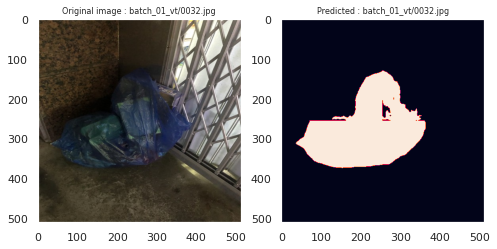

In [110]:
# 첫번째 batch의 추론 결과 확인
for imgs, image_infos in test_loader:
    image_infos = image_infos
    temp_images = torch.stack(imgs)
    
    model.eval()

    # inference by sliding window
    outs = torch.zeros_like(torch.empty(8,12,512,512))
    for sx, sy in [(0,0),(0,256),(256,0),(256,256)]:
        sub_image = temp_images[:,:,sx:sx+256, sy:sy+256]
        outs[:,:, sx:sx+256, sy:sy+256] = model(sub_image.to(device))
    oms = torch.argmax(outs,dim=1).detach().cpu()
    # inference
    # outs = model(torch.stack(temp_images).to(device))
    # oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
    
    break

i = 3
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))

print('Shape of Original Image :', list(temp_images[i].shape))
print('Shape of Predicted : ', list(oms[i].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(oms[i]))])

# Original image
ax1.imshow(temp_images[i].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("Original image : {}".format(image_infos[i]['file_name']), fontsize = 8)

# Predicted
ax2.imshow(oms[i])
ax2.grid(False)
ax2.set_title("Predicted : {}".format(image_infos[i]['file_name']), fontsize = 8)

plt.show()

## submission을 위한 test 함수 정의

In [111]:
def test(model, data_loader, device):
    size = 256
    transform = A.Compose([A.Resize(256, 256)])
    print('Start prediction.')
    model.eval()
    
    file_name_list = []
    preds_array = np.empty((0, size*size), dtype=np.long)
    
    with torch.no_grad():
        for step, (imgs, image_infos) in enumerate(tqdm(test_loader)):
            # if step>0: break
            imgs = torch.stack(imgs)
            # print(imgs.size()) # torch.Size([batch, 3, 512, 512])

            # inference by sliding window
            batch = imgs.size(0)
            start_points = [(0,0), (0,size), (size,0), (size,size)]
            outs = torch.zeros_like(torch.empty(batch,12,512,512)) #(batch,12,512,512)
            for sx, sy in start_points:
                subimgs = imgs[:, :, sx:sx+size, sy:sy+size]
                outs[:,:, sx:sx+size, sy:sy+size] = model(subimgs.to(device))
            oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()  # (batch,512,512)

            # inference (512 x 512)
            # outs = model(torch.stack(imgs).to(device))
            # oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
            
            # resize (256 x 256)
            temp_mask = []
            for img, mask in zip(np.stack(imgs), oms):
                transformed = transform(image=img, mask=mask)
                mask = transformed['mask']
                temp_mask.append(mask)

            oms = np.array(temp_mask)  # (batch,256,256)
            
            oms = oms.reshape([oms.shape[0], size*size]).astype(int) # (batch, 256*256)
            
            preds_array = np.vstack((preds_array, oms))  # (len(test_loader), 256*256) : vstack -> concate
            
            file_name_list.append([i['file_name'] for i in image_infos])
    print("End prediction.")
    file_names = [y for x in file_name_list for y in x]
    
    return file_names, preds_array

## submission.csv 생성

In [112]:
# sample_submisson.csv 열기
submission = pd.read_csv('./submission/sample_submission.csv', index_col=None)

# test set에 대한 prediction
file_names, preds = test(model, test_loader, device)

# PredictionString 대입
for file_name, string in zip(file_names, preds):
    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)

# submission.csv로 저장
submission.to_csv("./submission/P100_SEres50_AllAug_crop256_16_mIoU.csv", index=False)

Start prediction.



End prediction.
